In [71]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [95]:
filename = 'C:/Users/Lorenzo/Documents/Lubiana/Nnst/Data/camera22.npy'
data = np.load(filename)

In [94]:
#scipy.io.savemat('data.mat', {'data': avg})

In [96]:
(x, y, w, h) = 38, 78, 5, 5 # vert mode area
#(x, y, w, h) = 29, 84, 5, 5 # hor mode area

In [97]:
cut = data[:,y:(y+h),x:(x+w)]
avg = np.mean(cut, axis = (1,2))

In [98]:
signal = avg

In [99]:
sampling_freq = 400
nsec = 0.01
overlap = 0 
confidence = 95

In [100]:
ent_stdv = np.std(signal)

coeff = [1.645, 1.96, 2.326, 2.576]
conf = [90,95,98,99]
sigma = coeff[conf.index(confidence)]

w_point = int(sampling_freq * nsec) # Number of point for each window
lap = int(w_point * overlap)        # Number of point overlapped
L = len(signal)                     # length of the signal
dist = w_point - lap                # Number of point for each compartment
cmp = int(np.floor(L/(dist)))       # Number of compartment

stdv = np.empty(cmp)
cls = np.empty((cmp,dist))

for i in range(0,cmp):
    cls[i] = signal[i*dist:i*dist+dist]
    stdv[i] = np.std(cls[i])
        
if L % dist != 0:
    res_cmp = signal[cmp*dist+1:]
    stdv = np.append(stdv, np.std(res_cmp))
else:
    pass

## Definition of boundaries
boundUP = ent_stdv + np.std(stdv)
boundDW = ent_stdv - np.std(stdv)

run = np.empty(0)

for i in range(0,stdv.shape[0]):
    if stdv[i] > boundUP or stdv[i] < boundDW:
        run = np.append(run,1)
    else:
        run = np.append(run,0)
        
N1 = 0
N0 = 0

for i in range(0,len(run)):
    if run[i] == 1.:
        N1 += 1
    else:
        N0 += 1
        
N = N1 + N0
Nr = 0

for i in range(1,len(run)):
    if run[i] != run[i-1]:
        Nr += 1
        
## Definition of expected runs and of the variance of their distribution 
mean_val = (2 * N1 * N0) / N + 1
var = (2 * N1 * N0 * (2 * N1 * N0 - N)) / (N**2 * (N - 1))

## Definition of limits
lim_up = mean_val + sigma * np.sqrt(var)
lim_dw = mean_val - sigma * np.sqrt(var)

index_up = np.round(100 * lim_up / mean_val, 3)
index_dw = np.round(100 * lim_dw / mean_val, 3)

## True == Stationary & False == Non-stationary
if Nr >= lim_dw and Nr <= lim_up:
    bns = True
else:
    bns = False
    
## Index of non-stationary
index = 100 * Nr / mean_val 
if index > 100:
    index = 100
else:
    index = np.round(index,2)
    
nnst = {'index': index, 'bns':bns, 'ind_dw':index_dw, 'ind_up':index_up}

<IPython.core.display.Javascript object>


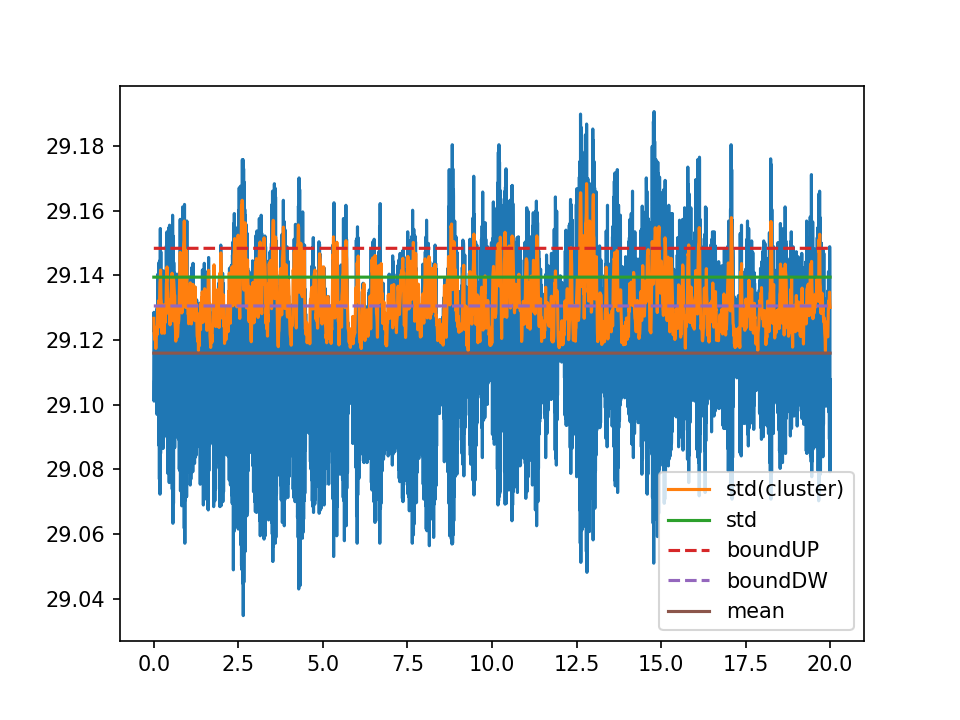

In [101]:
%matplotlib notebook
plt.plot(time,signal)
plt.plot(np.linspace(0,20,cmp),np.mean(signal)+stdv, label = 'std(cluster)')
plt.plot(time,np.linspace(np.mean(signal)+np.std(signal),np.mean(signal)+np.std(signal),T*f_sample), label = 'std')
plt.plot(time,np.linspace(np.mean(signal)+boundUP,np.mean(signal)+boundUP,T*f_sample),'--', label = 'boundUP')
plt.plot(time,np.linspace(np.mean(signal)+boundDW,np.mean(signal)+boundDW,T*f_sample),'--', label = 'boundDW')
plt.plot(time,np.linspace(np.mean(signal),np.mean(signal),T*f_sample), label = 'mean')
plt.legend()

In [102]:
nnst

{'index': 44.74, 'bns': False, 'ind_dw': 95.623, 'ind_up': 104.377}

In [106]:
boundUP

0.032378967163003244

In [107]:
boundDW

0.014568199160658558

In [103]:
Nr

444

In [104]:
N1

1093

In [105]:
N

2000

In [86]:
N0

778

In [88]:
mean_val

951.716

In [89]:
ent_stdv

0.035906523

In [90]:
var

451.6809387973987

In [108]:
ent_stdv

0.023473583

In [110]:
cmp

2000

In [111]:
cls.shape

(2000, 4)